# Test `tide_stn_water_level` Module

Render figure object produced by the `nowcast.figures.fvcom.tide_stn_water_level` module.
Provides data for visual testing to confirm that refactoring has not adversely changed figure for web page.

Set-up and function call replicates as nearly as possible what is done in the `nowcast.workers.make_plots` worker.

Notebooks like this should be developed in a
[Nowcast Figures Development Environment](https://salishsea-nowcast.readthedocs.io/en/latest/figures/fig_dev_env.html)
so that all of the necessary dependency packages are installed.
The development has to be done on a workstation that has the Salish Sea Nowcast system `/results/` parition mounted.

In [1]:
import io
from pathlib import Path
import shlex
import subprocess

import arrow
import xarray
import yaml

from nowcast.figures.fvcom import tide_stn_water_level

In [2]:
%matplotlib inline

The bits of `config/nowcast.yaml` that are required:

In [3]:
config = '''
    figures:
        dataset URLs:
            HRDPS fields: https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1
            tide stn ssh time series:
                # **Must be quoted to project {} characters**
                'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSf{place}SSH10mV17-02'
                
    vhfr fvcom runs:
        ssh dataset filename: vhfr_low_v2_station_timeseries.nc
        results archive:
            nowcast: /opp/fvcom/nowcast/
'''

config = yaml.load(io.StringIO(config))

The bits that the `make_figures` worker must provide:

In [4]:
run_date = arrow.get('2018-02-20')
run_type = 'nowcast'

ddmmmyy = run_date.format('DDMMMYY').lower()

results_home = Path(config['vhfr fvcom runs']['results archive'][run_type])
results_dir = results_home/ddmmmyy

fvcom_ssh_dataset_filename = config['vhfr fvcom runs']['ssh dataset filename']
fvcom_ssh_dataset_path = results_dir/fvcom_ssh_dataset_filename
cmd = (
    f'ncrename -O -v siglay,sigma_layer -v siglev,sigma_level '
    f'{fvcom_ssh_dataset_path} /tmp/{fvcom_ssh_dataset_path.name}')
subprocess.check_output(shlex.split(cmd))
fvcom_ssh_dataset = xarray.open_dataset(f'/tmp/{fvcom_ssh_dataset_path.name}')

nemo_ssh_dataset_url_tmpl = config['figures']['dataset URLs']['tide stn ssh time series']

/media/doug/warehouse/conda_envs/nowcast-fig-dev/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


1min 45s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


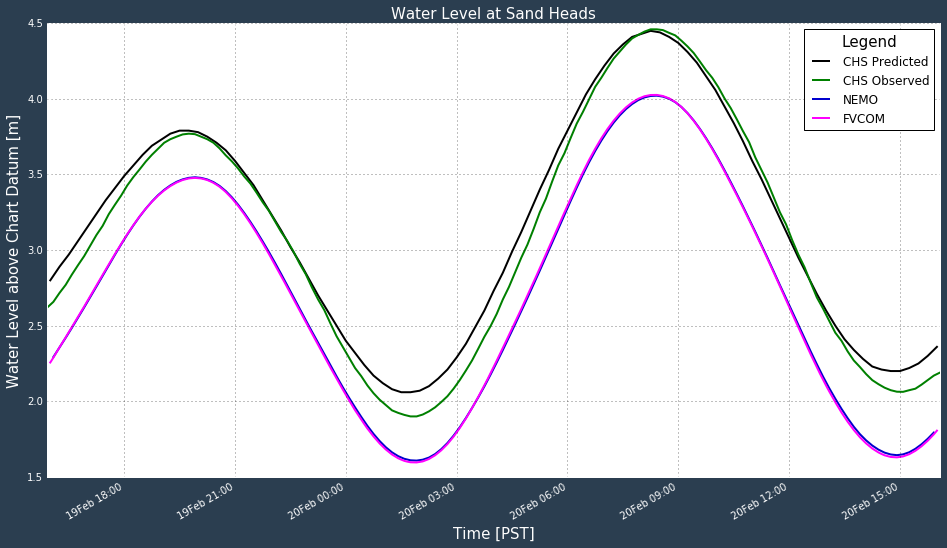

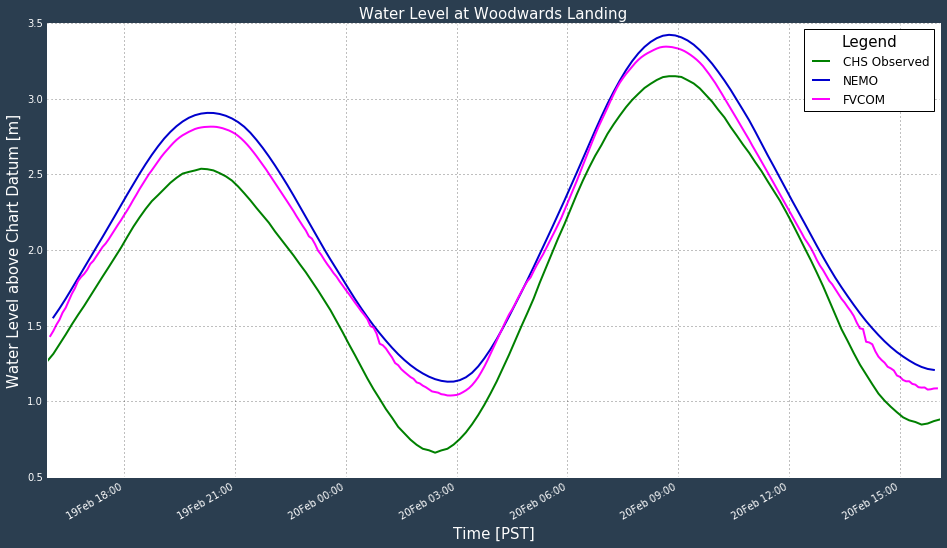

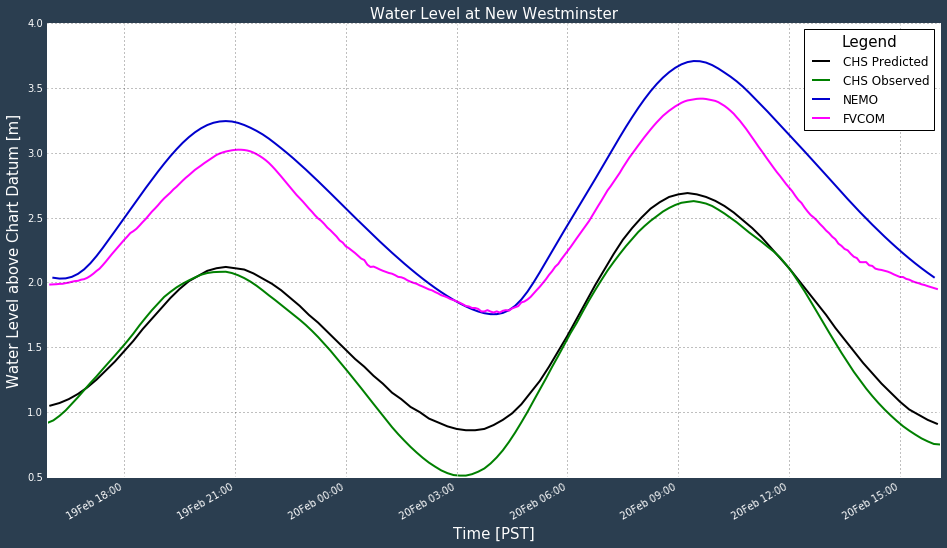

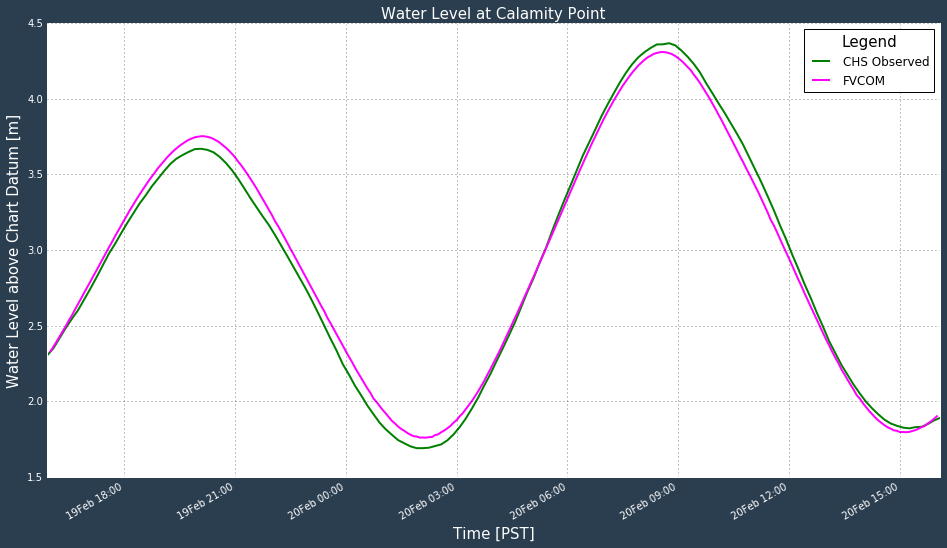

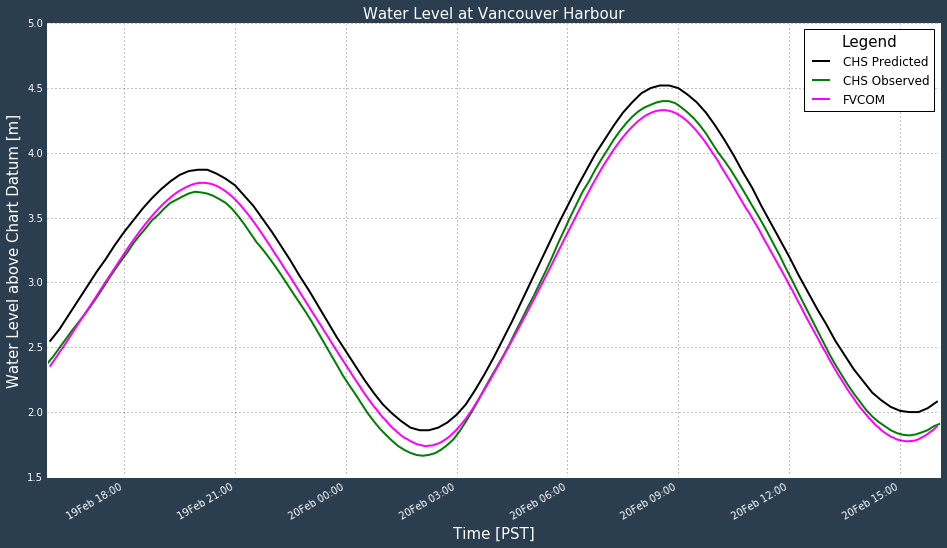

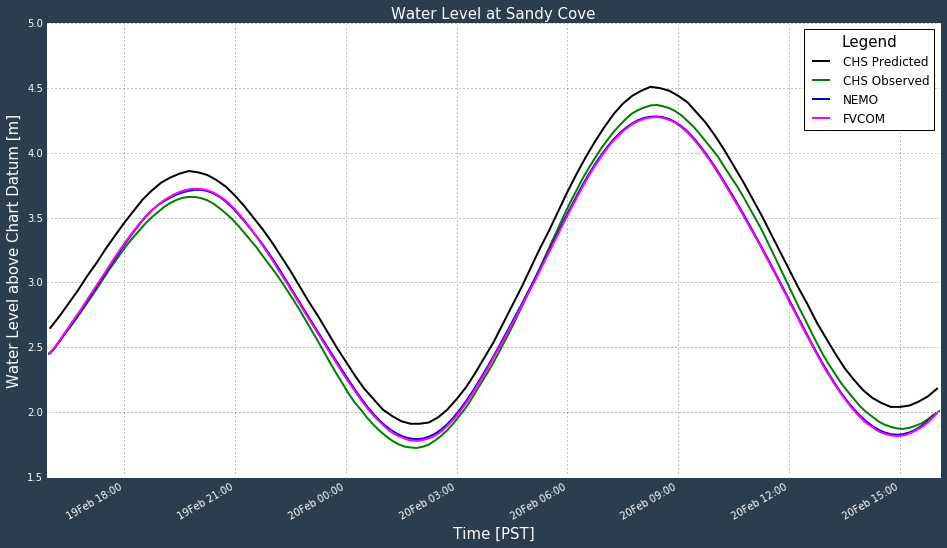

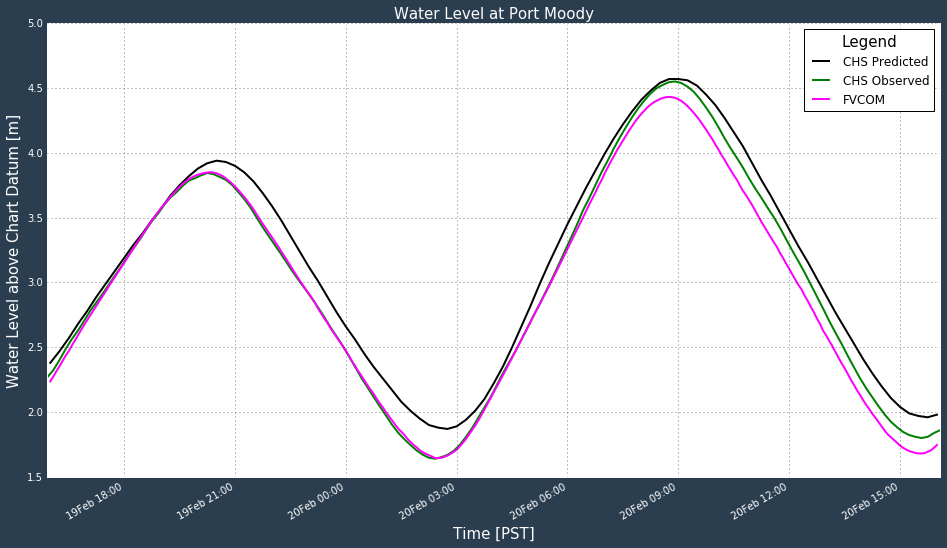

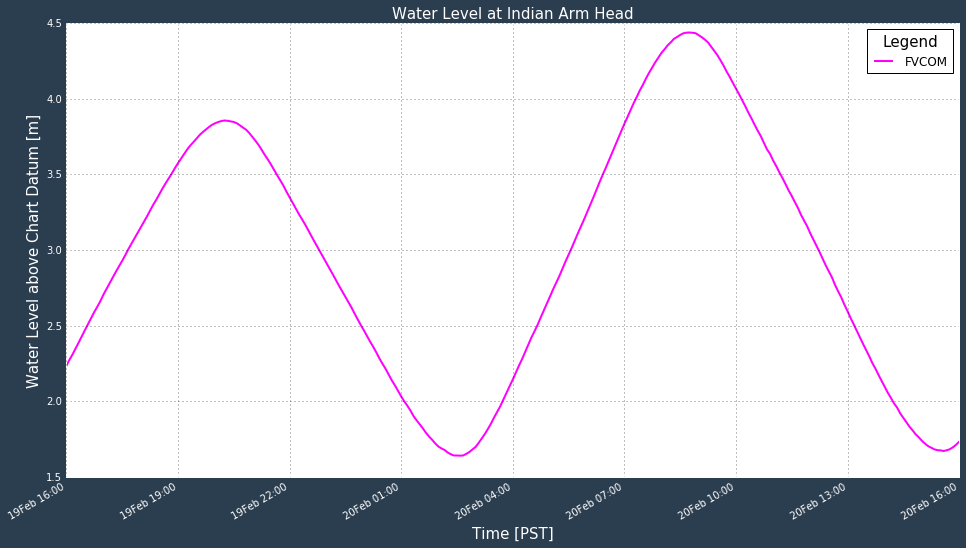

In [5]:
%%timeit -n1 -r1

from importlib import reload
reload(tide_stn_water_level)

stations = [
    name.decode().strip().split(maxsplit=1)[1]
    for name in fvcom_ssh_dataset.name_station.values
]
for station in stations:
    fig = tide_stn_water_level.make_figure(station, fvcom_ssh_dataset, nemo_ssh_dataset_url_tmpl)